<a href="https://colab.research.google.com/github/Ermi1223/conditional-diffusion-tutorial/blob/main/conditional_diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Conditional diffusion model**

**Step 1: Setup GPU Acceleration**

In [ ]:
# First cell: Setup GPU
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: Tesla T4


**Step 2: Install Required Packages**

In [ ]:
# Second cell: Install dependencies
!pip install torch torchvision matplotlib tqdm ipywidgets
!pip install diffusers transformers
!pip install diffusers transformers accelerate
!pip install pytorch-fid torch-fidelity scipy ftfy regex
!pip install git+https://github.com/openai/CLIP.git
!pip install torch-fidelity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-3a_cbu9g
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-3a_cbu9g
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=3dbe0015148fb8cac2a41d21d0d34a6aa399f2b21356551c609b8a66947eef66
  Stored in directory: /tmp/pip-ephem-wheel-cache-aa2dbmr1/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


**Step 3: Import Libraries and Configuration**

In [ ]:
# Cell 2: Import Libraries and Config
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from diffusers import DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image
from torch_fidelity import calculate_metrics
# Configuration
IMG_SIZE = 32
BATCH_SIZE = 64
TIMESTEPS = 500  # Reduced for faster training
NUM_EPOCHS = 10  # Reduced for demonstration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Using device: cuda
PyTorch version: 2.6.0+cu124
GPU: Tesla T4


**Step 4: Dataset Preparation**

In [ ]:
# Load CLIP once (global)
clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
clip_text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE).eval()

# Precompute embeddings (only 10 CIFAR classes)
class_to_text = {
    0: "an airplane flying in the sky",
    1: "an automobile on the road",
    2: "a bird perched on a branch",
    3: "a cat sitting on a windowsill",
    4: "a deer in the forest",
    5: "a dog playing in the park",
    6: "a frog on a lily pad",
    7: "a horse running in a field",
    8: "a ship sailing on the ocean",
    9: "a truck driving on the highway"
}

precomputed_embeddings = {}
for label, text in class_to_text.items():
    inputs = clip_tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
    with torch.no_grad():
        text_emb = clip_text_encoder(**inputs).last_hidden_state.mean(dim=1)
    precomputed_embeddings[label] = text_emb.squeeze(0).cpu()  # move to CPU for safety

# Dataset Class
class CIFAR10Conditional(Dataset):
    def __init__(self, root, train=True):
        super().__init__()
        self.cifar = datasets.CIFAR10(
            root=root, train=train, download=True,
            transform=transforms.Compose([
                transforms.Resize(IMG_SIZE),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])
            ])
        )

    def __len__(self):
        return len(self.cifar)

    def __getitem__(self, idx):
        img, label = self.cifar[idx]
        text_emb = precomputed_embeddings[label]
        return img, label, text_emb

# Load Data
train_dataset = CIFAR10Conditional(root='./data', train=True)
test_dataset = CIFAR10Conditional(root='./data', train=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)



print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 50000
Test dataset size: 10000


In [ ]:
class CIFAR10Conditional(Dataset):
    def __init__(self, root, train=True):
        super().__init__()
        self.cifar = datasets.CIFAR10(root=root, train=train, download=True,
                                      transform=transforms.Compose([
                                          transforms.Resize(IMG_SIZE),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.5], [0.5])
                                      ]))
        self.prompt_templates = {
            0: ["a red airplane in the sky", "an airplane flying over mountains"],
            1: ["a black car on the road", "a sports car racing"],
            2: ["a bird perched on a tree", "a bird flying over water"],
            3: ["a cat sitting on a sofa", "a kitten near a window"],
            4: ["a deer in the forest", "a deer running in snow"],
            5: ["a dog playing in grass", "a puppy on the beach"],
            6: ["a frog on a lily pad", "a green frog in a pond"],
            7: ["a horse running in the field", "a horse in the mountains"],
            8: ["a ship sailing at sunset", "a boat on the ocean"],
            9: ["a truck on a highway", "a delivery truck in rain"]
        }
        self.tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
        self.text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)

    def __len__(self):
        return len(self.cifar)

    def __getitem__(self, idx):
        img, label = self.cifar[idx]
        text = np.random.choice(self.prompt_templates[label])
        inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        with torch.no_grad():
            text_emb = self.text_encoder(**inputs).last_hidden_state.mean(dim=1)
        return img, label, text_emb.squeeze(0).cpu()

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=0)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 50000
Test dataset size: 10000


**Step 5: Model Architecture**

In [ ]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, device=DEVICE) * -(np.log(10000.0) / (half_dim - 1)))
        emb = t[:, None] * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

class ConditionalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim, cond_dim):
        super().__init__()
        self.time_layer = nn.Sequential(nn.Linear(time_dim, out_ch), nn.SiLU())
        self.cond_layer = nn.Sequential(nn.Linear(cond_dim, out_ch), nn.SiLU())
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.GroupNorm(8, out_ch), nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.GroupNorm(8, out_ch), nn.SiLU()
        )
        self.residual = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb, c_emb):
        h = self.conv(x) + self.residual(x)
        scale = self.time_layer(t_emb) + self.cond_layer(c_emb)
        scale = scale.view(scale.shape[0], scale.shape[1], 1, 1)
        return h * scale

class ConditionalUNet(nn.Module):
    def __init__(self):
        super().__init__()
        time_dim = 128
        cond_dim = 512

        self.time_mlp = nn.Sequential(TimeEmbedding(time_dim), nn.Linear(time_dim, time_dim), nn.SiLU(), nn.Linear(time_dim, time_dim))
        self.cond_proj = nn.Sequential(nn.Linear(cond_dim, cond_dim), nn.SiLU(), nn.Linear(cond_dim, cond_dim))

        self.down1 = ConditionalBlock(3, 32, time_dim, cond_dim)
        self.down2 = ConditionalBlock(32, 64, time_dim, cond_dim)
        self.down3 = ConditionalBlock(64, 128, time_dim, cond_dim)

        self.bottleneck = ConditionalBlock(128, 256, time_dim, cond_dim)

        self.up1 = ConditionalBlock(256 + 128, 128, time_dim, cond_dim)
        self.up2 = ConditionalBlock(128 + 64, 64, time_dim, cond_dim)
        self.up3 = ConditionalBlock(64 + 32, 32, time_dim, cond_dim)

        self.out = nn.Conv2d(32, 3, 1)
        self.downsample = nn.AvgPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x, t, _, text_emb):
        t_emb = self.time_mlp(t)
        c_emb = self.cond_proj(text_emb)

        d1 = self.down1(x, t_emb, c_emb)
        d2 = self.down2(self.downsample(d1), t_emb, c_emb)
        d3 = self.down3(self.downsample(d2), t_emb, c_emb)

        b = self.bottleneck(self.downsample(d3), t_emb, c_emb)

        u1 = self.up1(torch.cat([self.upsample(b), d3], dim=1), t_emb, c_emb)
        u2 = self.up2(torch.cat([self.upsample(u1), d2], dim=1), t_emb, c_emb)
        u3 = self.up3(torch.cat([self.upsample(u2), d1], dim=1), t_emb, c_emb)

        return self.out(u3)

model = ConditionalUNet().to(DEVICE)

# Create model
model = ConditionalUNet().to(DEVICE)
print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")

Model created with 3,068,387 parameters


**Step 6:Diffusion Utilities**

In [ ]:
class Diffusion:
    def __init__(self, timesteps=500, device='cuda'):
        self.timesteps = timesteps
        self.device = device

        self.betas = torch.linspace(1e-4, 0.02, timesteps, device=self.device)
        self.alphas = 1. - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0).to(self.device)  # <— this line is crucial


    def forward_process(self, x0, t):
        sqrt_alpha_bar = torch.sqrt(self.alpha_bars[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bars[t])[:, None, None, None]
        noise = torch.randn_like(x0)
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise

    @torch.no_grad()
    def ddim_step(self, model, x, t, t_prev, text_emb, guidance_scale=5.0):
        null_text = torch.zeros_like(text_emb).to(DEVICE)
        noise_cond = model(x, t, None, text_emb)
        noise_uncond = model(x, t, None, null_text)
        noise_pred = noise_uncond + guidance_scale * (noise_cond - noise_uncond)

        alpha_t = self.alpha_bars[t][:, None, None, None]
        alpha_t_prev = self.alpha_bars[t_prev][:, None, None, None]

        sqrt_alpha_t = torch.sqrt(alpha_t)
        sqrt_alpha_t_prev = torch.sqrt(alpha_t_prev)

        pred_x0 = (x - torch.sqrt(1 - alpha_t) * noise_pred) / sqrt_alpha_t
        dir_xt = torch.sqrt(1 - alpha_t_prev) * noise_pred

        x_prev = sqrt_alpha_t_prev * pred_x0 + dir_xt

        return x_prev

# Initialize diffusion utilities
diffusion = Diffusion(timesteps=TIMESTEPS, device=DEVICE)
print(f"Diffusion process initialized with {TIMESTEPS} timesteps")

Diffusion process initialized with 500 timesteps


**Step7: Training Function**

In [ ]:
def train_diffusion_model(model, diffusion, train_loader, num_epochs=NUM_EPOCHS, device=DEVICE):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for imgs, labels, text_embs in progress_bar:
            imgs = imgs.to(device)
            text_embs = text_embs.to(device)

            t = torch.randint(0, diffusion.timesteps, (imgs.size(0),), device=device).long()
            noisy_imgs, noise = diffusion.forward_process(imgs, t)

            noise_pred = model(noisy_imgs, t, None, text_embs)

            loss = F.mse_loss(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1} finished | Average Loss: {avg_loss:.4f}")

    return model
# Start training
print("Starting training...")
trained_model = train_diffusion_model(model, diffusion, train_loader)
print("Training completed!")

Starting training...


Epoch 1/10: 100%|██████████| 782/782 [00:46<00:00, 16.86it/s, loss=0.0576]


Epoch 1 finished | Average Loss: 0.1203


Epoch 2/10: 100%|██████████| 782/782 [00:46<00:00, 16.90it/s, loss=0.0375]


Epoch 2 finished | Average Loss: 0.0685


Epoch 3/10: 100%|██████████| 782/782 [00:46<00:00, 16.97it/s, loss=0.0603]


Epoch 3 finished | Average Loss: 0.0620


Epoch 4/10: 100%|██████████| 782/782 [00:46<00:00, 16.84it/s, loss=0.0626]


Epoch 4 finished | Average Loss: 0.0604


Epoch 5/10: 100%|██████████| 782/782 [00:46<00:00, 16.84it/s, loss=0.0681]


Epoch 5 finished | Average Loss: 0.0578


Epoch 6/10: 100%|██████████| 782/782 [00:46<00:00, 16.80it/s, loss=0.131]


Epoch 6 finished | Average Loss: 0.0564


Epoch 7/10: 100%|██████████| 782/782 [00:46<00:00, 16.65it/s, loss=0.0129]


Epoch 7 finished | Average Loss: 0.0560


Epoch 8/10: 100%|██████████| 782/782 [00:46<00:00, 16.77it/s, loss=0.022]


Epoch 8 finished | Average Loss: 0.0549


Epoch 9/10: 100%|██████████| 782/782 [00:46<00:00, 16.71it/s, loss=0.0513]


Epoch 9 finished | Average Loss: 0.0538


Epoch 10/10: 100%|██████████| 782/782 [00:46<00:00, 16.72it/s, loss=0.0762]

Epoch 10 finished | Average Loss: 0.0536
Training completed!


**Step 8: Sampling and Visualization Functions**

In [ ]:
import clip

@torch.no_grad()
def sample_ddim(model, diffusion, num_samples=1, text_prompt=None, guidance_scale=5.0, steps=50, device='cuda'):
    model.eval()
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

    if text_prompt is None:
        text_emb = torch.zeros(num_samples, 512).to(device)
    else:
        inputs = tokenizer([text_prompt] * num_samples, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        text_emb = text_encoder(**inputs).last_hidden_state.mean(dim=1)

    x = torch.randn(num_samples, 3, 32, 32).to(device)
    timesteps = torch.linspace(diffusion.timesteps - 1, 0, steps).long()

    for i in range(steps - 1):
        t = timesteps[i].repeat(num_samples).to(device)
        t_prev = timesteps[i + 1].repeat(num_samples).to(device)
        x = diffusion.ddim_step(model, x, t, t_prev, text_emb, guidance_scale=guidance_scale)

    return x.clamp(-1, 1)


def visualize_samples(samples, title="Generated Samples"):
    samples = samples.cpu().permute(0, 2, 3, 1)
    samples = (samples + 1) / 2
    samples = samples.clamp(0, 1)

    plt.figure(figsize=(12, 3))
    for i in range(min(4, samples.shape[0])):
        plt.subplot(1, 4, i + 1)
        plt.imshow(samples[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def save_images(samples, folder="generated_images"):
    os.makedirs(folder, exist_ok=True)
    for i, img in enumerate(samples):
        img_path = f"{folder}/sample_{i}.png"
        img_pil = transforms.ToPILImage()((img.cpu() + 1) / 2)
        img_pil.save(img_path)
    print(f"Saved {len(samples)} images to {folder}")


def evaluate_fid_is(generated_dir, real_dir="./data/cifar10_png"):
    metrics = calculate_metrics(
        input1=generated_dir,
        input2=real_dir,
        cuda=torch.cuda.is_available(),
        isc=True,
        fid=True,
        kid=False
    )
    print("FID:", metrics['frechet_inception_distance'])
    print("Inception Score:", metrics['inception_score_mean'])
    return metrics


device_clip = 'cuda' if torch.cuda.is_available() else 'cpu'
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device_clip)


def compute_clipscore(image_tensor, prompt):
    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    image = ((image + 1) * 127.5).astype(np.uint8)
    pil_image = Image.fromarray(image)
    image_input = clip_preprocess(pil_image).unsqueeze(0).to(device_clip)
    text_input = clip.tokenize([prompt]).to(device_clip)

    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
        text_features = clip_model.encode_text(text_input)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = (image_features @ text_features.T).item()
    return similarity


def batch_clipscore(samples, prompt):
    scores = []
    for i in range(samples.shape[0]):
        scores.append(compute_clipscore(samples[i], prompt))
    avg_score = np.mean(scores)
    print(f"Average CLIPScore for prompt '{prompt}': {avg_score:.4f}")
    return avg_score

100%|███████████████████████████████████████| 338M/338M [00:24<00:00, 14.4MiB/s]


**Step 9:Experiment Workflow**

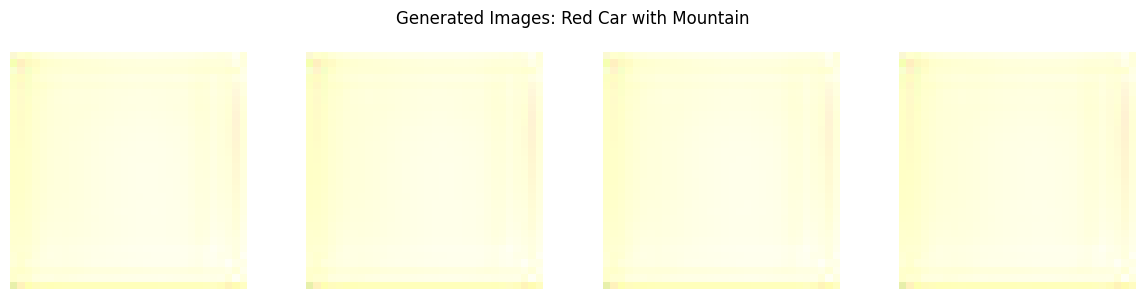

Saved 8 images to generated_images
Average CLIPScore for prompt 'a red car with mountain background': 0.1846


np.float64(0.1845703125)

In [ ]:
# Generate images
samples = sample_ddim(trained_model, diffusion, num_samples=8, text_prompt="a red car with mountain background", guidance_scale=7.5)

# Visualize
visualize_samples(samples, title="Generated Images: Red Car with Mountain")

# Save images
save_images(samples, folder="generated_images")

# Evaluate CLIPScore
batch_clipscore(samples, prompt="a red car with mountain background")


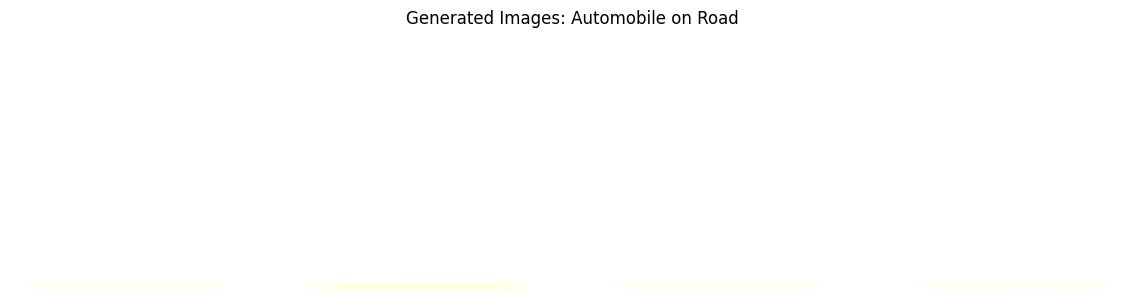

Average CLIPScore for prompt 'an automobile on the road': 0.2038


np.float64(0.2037811279296875)

In [ ]:
samples = sample_ddim(trained_model, diffusion, num_samples=8, text_prompt="an automobile on the road", guidance_scale=7.5)
visualize_samples(samples, title="Generated Images: Automobile on Road")
batch_clipscore(samples, "an automobile on the road")
